## Import something needed

In [1]:
import numpy as np 

import scipy as sp
import scipy.linalg as la   # la.eig()
import scipy.integrate
from scipy.integrate import odeint
from scipy.linalg import eigh  

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif']=['SimHei']  
plt.rcParams['axes.unicode_minus']=False   

## One-meter beam is divided into ten parts

Text(0.5, 1.0, 'initial conditions')

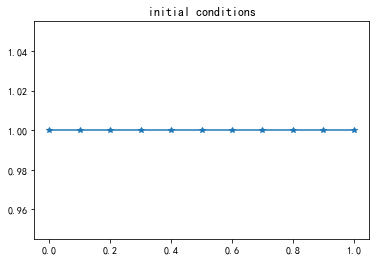

In [2]:
L = 1           # Beam length = 1 m
num = 10        # divided into 10 parts
num_elems = num+1
x = np.linspace(0,L,num_elems)   #x.shape =11

ini_shape= [ 1 for i in range(num_elems) ]
plt.plot(x,ini_shape,marker='*')
plt.title("initial conditions")

## Define material properties and element properties

In [3]:
l = x[1]-x[0]   # element length 
E = 8*10**5     # Young's modulus
u = 0.3         # Poisson's ratio
I = 763*10**-11 # Moment of inertia
Rho = 1000      # Material density
cc = 0.2        # Damping coefficient
q = 10         # Distribution force
t = np.linspace(0, 10, 101) # time series

k = (E*I/l**3)*np.array([ [12,6*l,-12,6*l],                     # element Stiffness matrix
                          [6*l,4*l**2,-6*l,2*l**2],
                          [-12,-6*l,12,-6*l],
                          [6*l,2*l**2,-6*l,4*l**2] ])
m = (Rho*l/420)* np.array([ [156,22*l,54,-13*l],                # element mass matrix
                            [22*l,4*l**2,13*l,-3*l**2],
                            [54,13*l,156,-22*l],
                            [-13*l,-3*l**2,-22*l,4*l**2] ])
c = m*(cc/Rho)                                                  # element damping matrix 
f = np.array([0.5*q*l,0,0.5*q*l,0])                             # element force matrix

## Assemble the overall matrix

In [4]:
def beam_matrx_add(num_elems):
    """
    input:  Number of element
    return: M_end : Overall mass matrix without fixed end constraints
            K_end : Overall stiffness matrix without fixed end constraints
            C_end : Overall damping matrix without fixed end constraints
            F_end : Overall force matrix without fixed end constraints
            F     : Overall force matrix
    """
    M = np.zeros((2*num_elems+2,2*num_elems+2))
    K = np.zeros((2*num_elems+2,2*num_elems+2))
    C = np.zeros((2*num_elems+2,2*num_elems+2))
    F = np.zeros(2*num_elems+2)
    
    for i in range(num_elems):
        M_temp = np.zeros((2*num_elems+2,2*num_elems+2))
        K_temp = np.zeros((2*num_elems+2,2*num_elems+2))
        C_temp = np.zeros((2*num_elems+2,2*num_elems+2))
        F_temp = np.zeros(2*num_elems+2)
        M_temp[2*i:2*i+4, 2*i:2*i+4] = m    
        K_temp[2*i:2*i+4, 2*i:2*i+4] = k    # Slice assignment
        C_temp[2*i:2*i+4, 2*i:2*i+4] = c
        F_temp[2*i:2*i+4] = f
        M += M_temp
        K += K_temp
        C += C_temp
        F += F_temp
    M_end = M[2:,2:]    #Remove fixed end degrees of freedom: The first two rows and the first two columns
    K_end = K[2:,2:]
    C_end = C[2:,2:]
    F_end = F[2:]
    return M_end , K_end ,C_end ,F_end , F
    
M , K , C , F_end , F = beam_matrx_add( num ) # K.shape =(20, 20)

## calculate the eigenvalue and the corresponding eigenvector

In [5]:
omega_2, fai = eigh(K,M)    # Return eigenvalues ​​and eigenvectors
omega = np.sqrt(omega_2)    # omega.shape = 20 # fai.shape = (20, 20)
print(omega)

[8.68677127e-03 5.44408216e-02 1.52469642e-01 2.98988244e-01
 4.95023141e-01 7.41600961e-01 1.04050213e+00 1.39398602e+00
 1.80240660e+00 2.24065143e+00 2.98220764e+00 3.60288253e+00
 4.36753134e+00 5.27131892e+00 6.33426663e+00 7.57583162e+00
 8.99133741e+00 1.04969585e+01 1.18207403e+01 1.47935175e+01]


## plot: Draw the first three modes

In [6]:
np.arange(0,1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

Text(0.5, 1.0, ' Vibration shape: displacement  ')

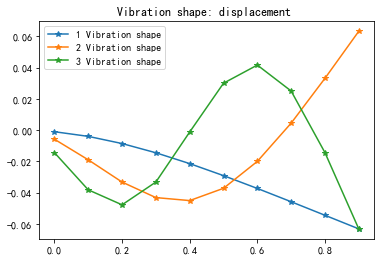

In [7]:
plt.plot(np.arange(0,1,1/num),-fai[::2, 0],label="1 Vibration shape",marker='*')
plt.plot(np.arange(0,1,1/num),-fai[::2,1],label="2 Vibration shape",marker='*')
plt.plot(np.arange(0,1,1/num),fai[::2, 2],label="3 Vibration shape",marker='*')  
plt.legend()
plt.title(" Vibration shape: displacement  ")

Text(0.5, 1.0, ' Vibration shape: angle ')

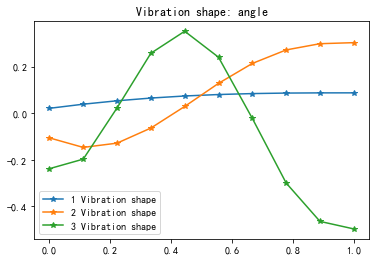

In [8]:
plt.plot(np.linspace(0,1,num), fai[1:22:2,0],label="1 Vibration shape",marker='*')
plt.plot(np.linspace(0,1,num),-fai[1:22:2,1],label="2 Vibration shape",marker='*')
plt.plot(np.linspace(0,1,num), fai[1:22:2,2],label="3 Vibration shape",marker='*')
plt.legend()
plt.title(" Vibration shape: angle ")

### Exact solutions in vibration mechanics

Text(0.5, 1.0, 'Analytical solution in vibration mechanics ')

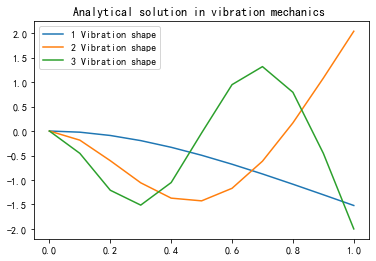

In [9]:
def static(i,x):
    beta_i = (2*i-1)*np.pi / (2*L)
    kexi_i = - ( np.cos(beta_i*L)+np.cosh(beta_i*L) ) / ( np.sin(beta_i*L)+np.sinh(beta_i*L) )
    fai_i = np.cos(beta_i*x) - np.cosh(beta_i*x) + kexi_i*(np.sin(beta_i*x)-np.sinh(beta_i*x))
    return fai_i
for i in range(1,4):
    plt.plot(x,static(i,x),label="{} Vibration shape".format(i))
    plt.legend()
plt.title("Analytical solution in vibration mechanics ")

## Solve ordinary differential equations

In [10]:
result = np.zeros( ( 101 , len(omega) ) )

def diff(y,t):                          # define ODE 
    yt, theta = y
    return theta , (F_i*2*np.sin(1000*t)-K_i*yt-C_i*theta) / M_i 
# # # # # # # # # # # # # # # # here make the force time related !!!!but【i do not know if it right or not】#  # # # # # # # # # # # # # # # #

for i in range( len(omega) ):           # Calculate the ODE corresponding to each eigenvalue
    M_i = (fai[:,i].T) @ M @ fai[:,i] 
    K_i = (fai[:,i].T) @ K @ fai[:,i] 
    C_i = (fai[:,i].T) @ C @ fai[:,i] 
    F_i = fai[: ,i].T  @ F_end        

    y0 = [1,0]                          # initial conditions
    sol = odeint(diff, y0, t)           # Call the odeint function to solve
    result[:,i] += sol[:,0]             # Put the result of each solution into the  "result" matrix
    
    # if i%2 == 0:
    #     plt.subplot(121)
    #     plt.plot(t,sol[:,0],label='i={}'.format(i) )
    #     plt.legend()
    
    # if i%2 == 1:
    #     plt.subplot(122)
    #     plt.plot(t,sol[:,0],label='i={}'.format(i) )
    #     plt.legend()
result.shape # =(101,20)

(101, 20)

## Superimpose to get the response of the original coordinates

In [11]:
x_result = np.zeros((20,101))
for i in range(len(omega)):
    x_result += fai[:,i].reshape(-1,1) @ result[:,i].reshape(1,-1) 
# x_result.shape # =(20, 101)

Text(0.5, 0.92, 'displacement of x')

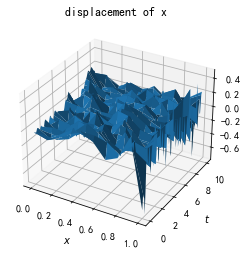

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num),t )
ax.plot_surface(X,T,x_result[::2,::].T)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_title('displacement of x')

Text(0.5, 0.92, 'Angle change')

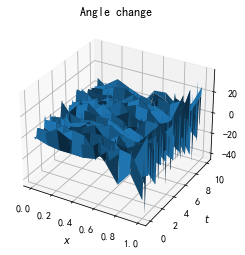

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num),t )
ax.plot_surface(X,T,x_result[1:2*num:2,::].T)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_title('Angle change')